<a href="https://colab.research.google.com/github/Iamdohyun/AI_EXPLORATION/blob/main/EX_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EX_13 인간보다 퀴즈를 잘푸는 인공지능

## 0. IMPORT

In [1]:
!pip install tensorflow_addons
!pip install sentencepiece
!pip install keras
!pip install tensorflow
!apt -qq -y install fonts-nanum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
!pip install backend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import seaborn as sns
from wordcloud import WordCloud

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

random_seed = 4902
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. DATA

### 1.1 DATA 불러오기

In [4]:
def print_json_tree(data, indent=""):
    for key, value in data.items(): # items() : key, value 한번에 가져오기
        if type(value) == list:
            print(f'{indent}-{key}:[{len(value)}]')
            print_json_tree(value[0], indent+" ") # 첫번째 아이템 출력
        else:
            print(f'{indent}-{key}:{value}')
            


!pip install back

위의 메소드는 Jason 포맷으로 이루어진 KorQuAD 데이터에서 내용을 간단히 확인 하는 메소드입니다.

In [5]:
data_dir = '/content/drive/MyDrive/bert_qna/data'
model_dir = '/content/drive/MyDrive/bert_qna/models'

데이터와 모델의 디렉토리를 설정해주는 작업입니다.

In [6]:
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

-version:KorQuAD_v1.0_train
-data:[1420]
 -paragraphs:[3]
  -qas:[8]
   -answers:[1]
    -text:교향곡
    -answer_start:54
   -id:6566495-0-0
   -question:바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
  -context:1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
 -title:파우스트_서곡


위에서 실행했던 메소드 함수를 사용하여 훈련데이터의 첫 아이템의 내용을 확인합니다.

In [7]:
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

-version:KorQuAD_v1.0_dev
-data:[140]
 -paragraphs:[2]
  -qas:[7]
   -answers:[1]
    -text:1989년 2월 15일
    -answer_start:0
   -id:6548850-0-0
   -question:임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
  -context:1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
 -title:임종석


data_dir 속의 dev 또한 위의 훈련데이터 처럼 첫 아이템만 확인해줍니다.

- **아래에서 실제 데이터의 형태를 확인해줍니다.**

In [8]:
print(json.dumps(train_json['data'][0], indent=2, ensure_ascii=False))

{
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "교향곡",
              "answer_start": 54
            }
          ],
          "id": "6566495-0-0",
          "question": "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?"
        },
        {
          "answers": [
            {
              "text": "1악장",
              "answer_start": 421
            }
          ],
          "id": "6566495-0-1",
          "question": "바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?"
        },
        {
          "answers": [
            {
              "text": "베토벤의 교향곡 9번",
              "answer_start": 194
            }
          ],
          "id": "6566495-0-2",
          "question": "바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?"
        },
        {
          "answers": [
            {
              "text": "파우스트",
              "answer_start": 15
            }
          ],
          "id": "6566518-0-0",
          "question": "1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?"
        },
        {
    

### 1.2 DATA 전처리

#### 1.2.1 whitespace 띄어쓰기

In [9]:
def _is_whitespace(c):
    if c == ' ' or c == '\t' or c == '\r' or c == '\n' or ord(c) == 0x202F:
        return True
    return False

띄어쓰기 단위 정보관리를 위한 메소드입니다.  
KorQuAD 데이터셋은 애석하게도 일반적인 자연어처리 태스크와는 다른 접근 법을 갖고 있습니다.  
~그냥 좀 같게 하지~ 취소선은 모르는 척 해주는게 의리이다.

In [10]:
string1 = '1839년 파우스트를 읽었다.'
string2 = '1839년  파우스트를 읽었다.'
string1[6:10], string2[7:11]

('파우스트', '파우스트')

In [11]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

for c in string1:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False
    char_to_word.append(len(word_tokens)-1)
    print(f'\'{c}\':{word_tokens} : {char_to_word}')

'1':['1'] : [0]
'8':['18'] : [0, 0]
'3':['183'] : [0, 0, 0]
'9':['1839'] : [0, 0, 0, 0]
'년':['1839년'] : [0, 0, 0, 0, 0]
' ':['1839년'] : [0, 0, 0, 0, 0, 0]
'파':['1839년', '파'] : [0, 0, 0, 0, 0, 0, 1]
'우':['1839년', '파우'] : [0, 0, 0, 0, 0, 0, 1, 1]
'스':['1839년', '파우스'] : [0, 0, 0, 0, 0, 0, 1, 1, 1]
'트':['1839년', '파우스트'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를':['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ':['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽':['1839년', '파우스트를', '읽'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었':['1839년', '파우스트를', '읽었'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다':['1839년', '파우스트를', '읽었다'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.':['1839년', '파우스트를', '읽었다.'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


첫번째 문장 string1은 띄어쓰기 1칸입니다. 

In [12]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

for c in string2:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False
    char_to_word.append(len(word_tokens)-1)
    print(f'\'{c}\':{word_tokens}:{char_to_word}')

'1':['1']:[0]
'8':['18']:[0, 0]
'3':['183']:[0, 0, 0]
'9':['1839']:[0, 0, 0, 0]
'년':['1839년']:[0, 0, 0, 0, 0]
' ':['1839년']:[0, 0, 0, 0, 0, 0]
' ':['1839년']:[0, 0, 0, 0, 0, 0, 0]
'파':['1839년', '파']:[0, 0, 0, 0, 0, 0, 0, 1]
'우':['1839년', '파우']:[0, 0, 0, 0, 0, 0, 0, 1, 1]
'스':['1839년', '파우스']:[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
'트':['1839년', '파우스트']:[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를':['1839년', '파우스트를']:[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ':['1839년', '파우스트를']:[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽':['1839년', '파우스트를', '읽']:[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었':['1839년', '파우스트를', '읽었']:[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다':['1839년', '파우스트를', '읽었다']:[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.':['1839년', '파우스트를', '읽었다.']:[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


두번째 문장 string2은 띄어쓰기 2칸입니다.

In [13]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True
    
    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False
        char_to_word.append(len(word_tokens)-1)
    
    return word_tokens, char_to_word

위의 기능들을 사용시 편의를 위해 함수를 만들어 줍니다.  
춘식이의 손은 믿을 수 없으니 만들어진 함수가 잘 나왔는지 확인 해 봅니다.

In [14]:
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

잘 나왔군요, 이어서 두번째 문장인 string2에 대해서도 확인해 봅니다.

In [15]:
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

두 번째 문장 역시 잘 나오는 것을 확인 했습니다.  
함수가 잘 만들어 졌네요, 이어서 두번째로 필요한 전처리 Tokenize 해보겠습니다.

#### 1.2.2 Tokenize... Made by ChunSik

말이 필요한가? 또 나왔다. Tokenize  
~그만 보고 싶다.~ 취소선은 그냥 넘어가자

In [16]:
ChunSik = spm.SentencePieceProcessor()
ChunSik.load(f'{model_dir}/ko_32000.model')

word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens):
    word_to_token.append(len(context_tokens))
    tokens = ChunSik.encode_as_pieces(word)
    for token in tokens:
        context_tokens.append(token)

context_tokens, word_to_token

(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

ChunSik 뭔가 하나의 브랜드 느낌이다 과거에는 섹시 도현이라는 닉네임을 미려고 했지만 한 퍼실님이 상당히 마음에 안 들어 하시는 것 같아서 바꾼 닉네임이다.  
Made by ChunSik 어떤가? 상당히 강해보인다.  
이제 이 작업을 또 함수로 만들어 보자

In [17]:
def _tokenize_ChunSik(ChunSik, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = ChunSik.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

춘식이가 만든 2번째 함수..
마찬가지로 성능을 확인해 보자

In [18]:
print(word_tokens)

['1839년', '파우스트를', '읽었다.']


굳 마음에 든다.

In [19]:
context_tokens, word_to_token = _tokenize_ChunSik(ChunSik, word_tokens)
context_tokens, word_to_token

(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

#### 1.2.3 Improve Span

어느덧 3번째 전처리에 도달했다.  
~지겹다~ 당신은 취소선을 보지 못하였다.  

애석하세고 이번 익스에는 상당히 귀찮은 것이 3개나 있다.  
context = 지문  
question = 질문  
answer = 정답  
후.. 너무 많다.  
~극혐~  마찬가지로 당신은 취소선을 보지 못하였다.
  
중요한 건 전처리 과정에서 우리는 정답에 해당하는 문맥을 잘 찾아야 한다. 그 작업을 해볼 것이다.

In [20]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


정답에 맞는 문맥 영역을 정확히 찾아한다.  특명이다.

In [21]:
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

문맥 부분의 띄어쓰기 단위로 토큰화한 결과를 살펴본것이 결과로 나왔다. 

In [22]:
context_tokens, word_to_token = _tokenize_ChunSik(ChunSik, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


띄어쓰기 단위로 쪼개진 문맥을 춘식이로 토큰화한 결과를 살펴보았다.  
다행이다. 잘 나와 주었다.

In [23]:
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

정답의 시작 부분과 마지막 부분으로부터 단어의 기작과 마지막 부분을 구한다.

In [ ]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

In [25]:
token_answer = " ".join(ChunSik.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

실제 정답도 Subword 기준으로 토큰화해 둔다.

In [26]:
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우!!!!!
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


우리는 위의 작업들 역시 함수화 해줄 것이다.

In [27]:
def _improve_span(ChunSik, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(ChunSik.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [28]:
token_start, token_end = _improve_span(ChunSik, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

다행이다. 잘 나와주었다.

#### 1.2.4 Dataset split

In [29]:
def dump_korquad(ChunSik, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_ChunSik(ChunSik, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(ChunSik, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": ChunSik.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [30]:
dump_korquad(ChunSik, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(ChunSik, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

전처리를 수행하여 파일로 생성한다.

In [31]:
def print_file(filename, count=10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

#### 1.2.5 데이터셋 분석

파일 만들어서 끝날 줄 알았죠?  
하지만.. 전처리는 아직도 남아있습니다.  
우리는 이상치를 점검 해줄겁니다.  
그리고 다양한 그래프를 그려볼 예정이에요  
~하.. 제발 전처리 그만~ 취소선이 보인 다면 당신은 제게 별 3개를 줍니다.

##### 1.2.5.1 Context 분석

In [32]:
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["context"])

19 ['▁1839', '년', '▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '을', '▁처음', '▁읽고', '▁그', '▁내용에', '▁마음이', '▁끌려', '▁이를', '▁소재로', '▁해서', '▁하나의', '▁교향곡', '을', '▁쓰', '려는', '▁뜻을', '▁갖는다', '.', '▁이', '▁시기', '▁바그너', '는', '▁1838', '년에', '▁빛', '▁독', '촉', '으로', '▁산', '전', '수', '전을', '▁다', '▁', '걲', '은', '▁상황이', '라', '▁좌절', '과', '▁실망', '에', '▁가득', '했으며', '▁메', '피스', '토', '펠', '레스', '를', '▁만나는', '▁', '파우스트', '의', '▁심', '경에', '▁공감', '했다고', '▁한다', '.', '▁또한', '▁파리에서', '▁아브', '네', '크의', '▁지휘', '로', '▁파리', '▁음악원', '▁관현악단', '이', '▁연주하는', '▁베토벤', '의', '▁교향곡', '▁9', '번을', '▁듣고', '▁깊은', '▁감', '명을', '▁받았는데', ',', '▁이것이', '▁이듬해', '▁1', '월에', '▁', '파우스트', '의', '▁서', '곡으로', '▁쓰여진', '▁이', '▁작품에', '▁조금', '이라도', '▁영향을', '▁끼', '쳤', '으리라', '는', '▁것은', '▁의심', '할', '▁여지가', '▁없다', '.', '▁여기', '의', '▁라', '단', '조', '▁조성', '의', '▁경우에도', '▁그의', '▁전기', '에', '▁적혀', '▁있는', '▁것처럼', '▁단순한', '▁정신적', '▁피로', '나', '▁실', '의', '가', '▁반영', '된', '▁것이', '▁아니라', '▁베토벤', '의', '▁합창', '교', '향', '곡', '▁조성', '의', '▁영향을', '▁받은', '▁것을', '▁볼', '▁수', '▁

In [33]:
# token count
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

위의 결과는 토큰이 몇개이인지 세준 결과물 입니다.

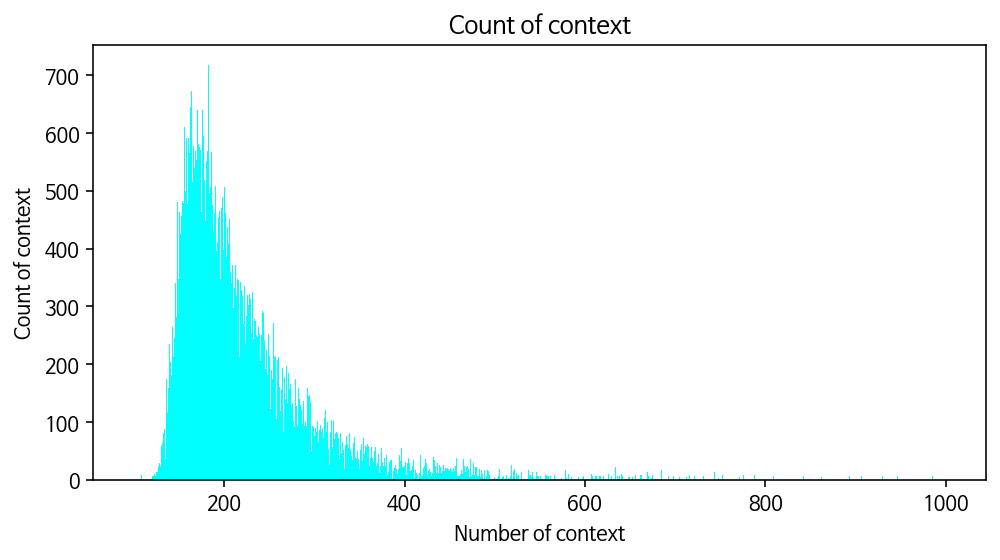

In [34]:
# 아래는 그래프의 사이즈
plt.figure(figsize=(8, 4))

plt.hist(train_context_counts, 
         bins=900, # bins: 히스토그램 값들에 대한 버켓 범위 
         range=[100, 1000], # range: x축 값의 범위
         facecolor='aqua', # facecolor: 그래프 색상 제 책상 앞에 2프로 아쿠아가 있으니 아쿠아로 합니다.
         label='train') # label: 그래프에 대한 라벨

# 그래프 제목
plt.title('Count of context')

# 그래프 x 축 라벨
plt.xlabel('Number of context')

# 그래프 y 축 라벨
plt.ylabel('Count of context')

# 그래프 출력 부탁해요~~~~~~~~~!
plt.show()

In [35]:
# 데이터 길이
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")

print("")

print(f"context 길이 최소:    {np.min(train_context_counts):4d}")

print("")

print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")

print("")

print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")

print("\n")

percentile25 = np.percentile(train_context_counts, 25)

percentile50 = np.percentile(train_context_counts, 50)

percentile75 = np.percentile(train_context_counts, 75)

percentileIQR = percentile75 - percentile25

percentileMAX = percentile75 + percentileIQR * 1.5

print(f"context 25/100분위:  {percentile25:7.2f}")

print("")

print(f"context 50/100분위:  {percentile50:7.2f}")

print("")

print(f"context 75/100분위:  {percentile75:7.2f}")

print("")

print(f"context IQR:        {percentileIQR:7.2f}")

print("")

print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:    4816

context 길이 최소:     108

context 길이 평균:     222.84

context 길이 표준편차:   97.68


context 25/100분위:   169.00

context 50/100분위:   199.00

context 75/100분위:   248.00

context IQR:          79.00

context MAX/100분위:  366.50


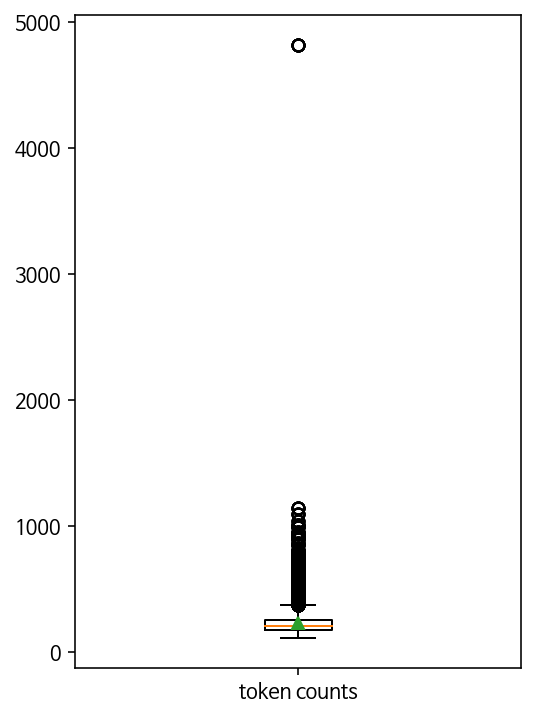

In [36]:
# 아래는 그래프의 사이즈입니다.
plt.figure(figsize=(4, 6))

# 우리는 박스 플롯 그래프를 나타낼 것 입니다.
plt.boxplot(train_context_counts, # 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
            labels=['token counts'], # labels: 입력한 데이터에 대한 라벨
            showmeans=True) # showmeans: 평균값을 표현

# 그래프 보여주세요
plt.show()

##### 1.2.5.2 Question 분석

Question도 위에서 한 것 처럼 동일하게 해줄 것입니다.  
다만 한가지 차이가 있다면 이번엔 설명과 주석은 추가 하지 않겠습니다.  
~손 아파요~ 취소선이 보이는데 모르는 척 넘어가 주는 것도 하나의 미덕 아닐까요? 

In [37]:
questions = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

19 ['▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '를', '▁읽고', '▁무엇을', '▁쓰고', '자', '▁', '했', '는', '가', '?']
168 ['▁바그너', '는', '▁교향곡', '▁작곡', '을', '▁어디', '까지', '▁쓴', '▁뒤에', '▁중단', '했', '는', '가', '?']
80 ['▁바그너', '가', '▁', '파우스트', '▁서', '곡을', '▁쓸', '▁때', '▁어떤', '▁곡', '의', '▁영향을', '▁받았', '는', '가', '?']
6 ['▁1839', '년', '▁바그너', '가', '▁교향곡', '의', '▁소재로', '▁쓰', '려고', '▁했던', '▁책은', '?']
143 ['▁', '파우스트', '▁서', '곡', '의', '▁라', '단', '조', '▁조성', '이', '▁영향을', '▁받은', '▁베토벤', '의', '▁곡은', '?']
0 ['▁바그너', '가', '▁', '파우스트', '를', '▁처음으로', '▁읽', '은', '▁', '년', '도', '는', '?']
165 ['▁바그너', '가', '▁처음', '▁교향곡', '▁작곡', '을', '▁한', '▁장소', '는', '?']
216 ['▁바그너', '의', '▁1', '악장', '의', '▁초연', '은', '▁어디서', '▁연주', '되었', '는', '가', '?']
164 ['▁바그너', '의', '▁작품을', '▁시인', '의', '▁피로', '▁쓰여', '졌다', '고', '▁극찬', '한', '▁것은', '▁누구', '인', '가', '?']
7 ['▁잊', '혀', '져', '▁있는', '▁', '파우스트', '▁서', '곡', '▁1', '악장', '을', '▁부활', '시킨', '▁것은', '▁누구', '인', '가', '?']


In [38]:
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

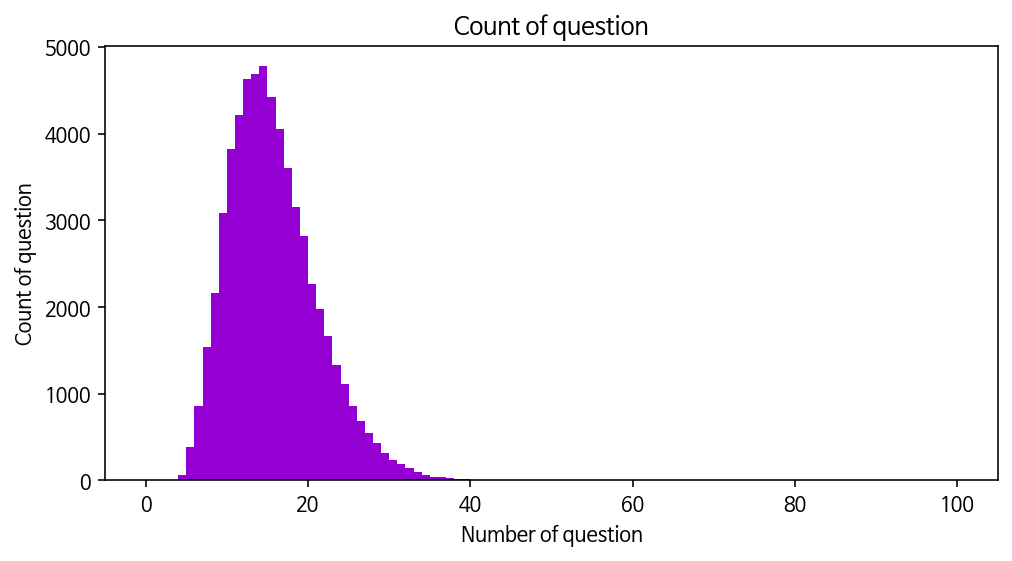

In [39]:
plt.figure(figsize=(8, 4))

plt.hist(train_question_counts, bins=100, range=[0, 100], 
         facecolor='darkviolet', # 이번 그래프 색상 춘식이가 좋아하는 보라색 고고!
         label='train') 

plt.title('Count of question')

plt.xlabel('Number of question')

plt.ylabel('Count of question')

plt.show()

In [40]:
# 데이터 길이
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")

print("")

print(f"question 길이 최소:    {np.min(train_question_counts):4d}")

print("")

print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")

print("")

print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")

print("\n")

percentile25 = np.percentile(train_question_counts, 25)

percentile50 = np.percentile(train_question_counts, 50)

percentile75 = np.percentile(train_question_counts, 75)

percentileIQR = percentile75 - percentile25

percentileMAX = percentile75 + percentileIQR * 1.5

print(f"question 25/100분위:  {percentile25:7.2f}")

print("")

print(f"question 50/100분위:  {percentile50:7.2f}")

print("")

print(f"question 75/100분위:  {percentile75:7.2f}")

print("")

print(f"question IQR:        {percentileIQR:7.2f}")

print("")

print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      58

question 길이 최소:       3

question 길이 평균:      15.25

question 길이 표준편차:    5.50


question 25/100분위:    11.00

question 50/100분위:    14.00

question 75/100분위:    18.00

question IQR:           7.00

question MAX/100분위:   28.50


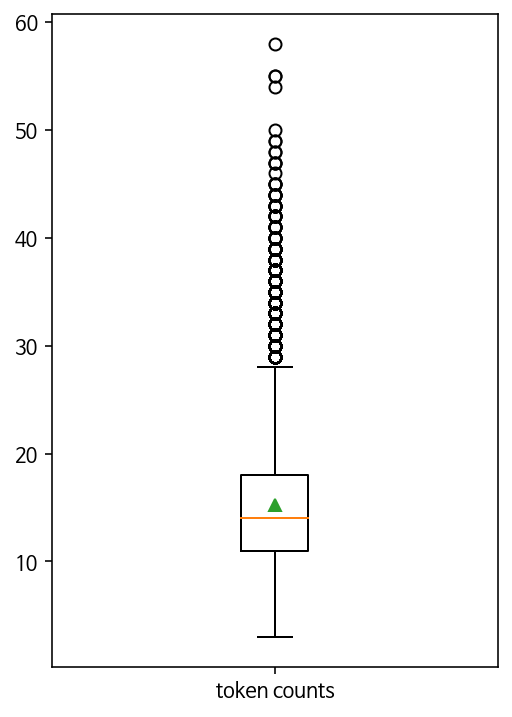

In [41]:
plt.figure(figsize=(4, 6))

plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True) 

plt.show()

##### 1.2.5.3 Answer 분석

정답도 분석을 할 텐데요 마찬가지로 주석과 설명은 빼도록 하겠습니다.

In [42]:
answers = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        answers.append(data["answer"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["answer"])

19 교향곡
168 1악장
80 베토벤의 교향곡 9번
6 파우스트
143 합창교향곡
0 1839
165 파리
216 드레스덴
164 한스 폰 뷜로
7 리스트


In [43]:
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

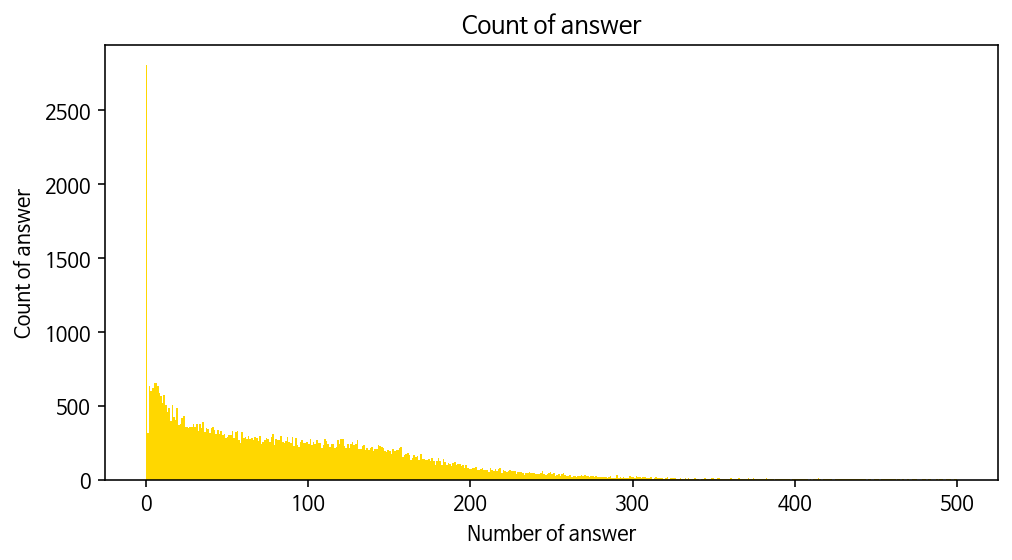

In [44]:
plt.figure(figsize=(8, 4))

plt.hist(train_answer_starts, bins=500, range=[0, 500], 
         facecolor='gold', # 이번 색상 gold 어떼여?!
         label='train') 

plt.title('Count of answer')

plt.xlabel('Number of answer')

plt.ylabel('Count of answer')

plt.show()

In [45]:
# 데이터 길이
print(f"answer 길이 최대:    {np.max(train_answer_starts):4d}")

print("")

print(f"answer 길이 최소:    {np.min(train_answer_starts):4d}")

print("")

print(f"answer 길이 평균:    {np.mean(train_answer_starts):7.2f}")

print("")

print(f"answer 길이 표준편차: {np.std(train_answer_starts):7.2f}")

print("\n")

percentile25 = np.percentile(train_answer_starts, 25)

percentile50 = np.percentile(train_answer_starts, 50)

percentile75 = np.percentile(train_answer_starts, 75)

percentileIQR = percentile75 - percentile25

percentileMAX = percentile75 + percentileIQR * 1.5

print(f"answer 25/100분위:  {percentile25:7.2f}")

print("")

print(f"answer 50/100분위:  {percentile50:7.2f}")

print("")

print(f"answer 75/100분위:  {percentile75:7.2f}")

print("")

print(f"answer IQR:        {percentileIQR:7.2f}")

print("")

print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 길이 최대:    1124

answer 길이 최소:       0

answer 길이 평균:      89.01

answer 길이 표준편차:   78.21


answer 25/100분위:    25.00

answer 50/100분위:    74.00

answer 75/100분위:   134.00

answer IQR:         109.00

answer MAX/100분위:  297.50


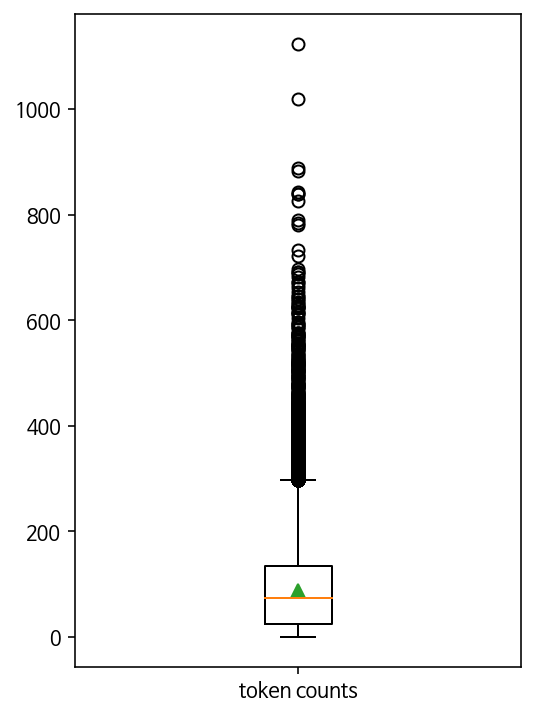

In [46]:
plt.figure(figsize=(4, 6))

plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True) 

plt.show()

#### 1.2.6 Word Cloud

In [47]:
# train documents
documents = []

# 전체 데이터에서 title, context, question 문장을 모두 추출합니다. 
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:20]   # 맨 앞 20개만 확인해 봅니다.

  0%|          | 0/1420 [00:00<?, ?it/s]

['파우스트_서곡',
 '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?',
 '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?',
 '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?',
 '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?',
 '바그너가 파우스트를 처음으로 읽은 년도는?',
 '바그너가 처음 교향곡 작곡을 한 장소는?',
 '바그너의 1악장의 초연은 어디서 연주되었는가?',
 '한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜

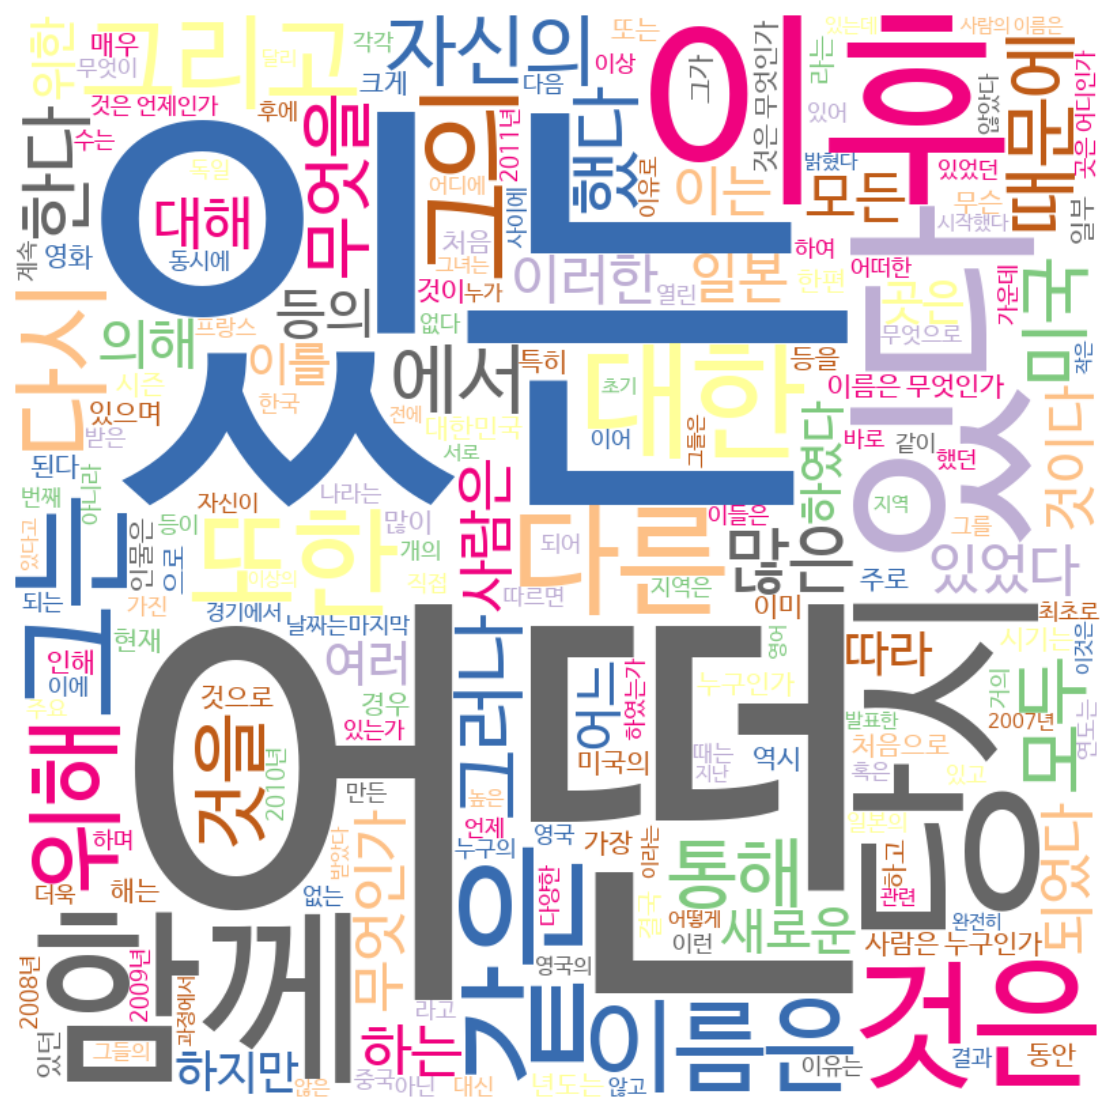

In [48]:
# WordCloud로 " ".join(documents)를 처리해 봅니다. 
wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white',
    colormap='Accent_r',
    font_path=fontpath
    ).generate(" ".join(documents))
plt.figure(figsize=(10, 10))
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

제일 처음 여기서 에러가 나왔는데 이럴땐  
!apt -qq -y install fonts-nanum 이걸 꼭 추가 하길 바란다.

#### 1.2.7 데이터로드

지금까지 우리가 고생해서 만든 모든 데이터셋을 메모리에 로드 합니다.

In [49]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [50]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_query_length': 64, 'max_seq_length': 384}

아래의 코드는 제가 생성한 데이터셋 파일을 메모리에 로딩하는 함수입니다.

In [51]:
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우는 처리하지 않게 설정합니다.
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [ChunSik.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))
#

In [52]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")

print("")

print(f"train_inputs: {train_inputs[1].shape}")

print("")

print(f"train_labels: {train_labels[0].shape}")

print("")

print(f"train_labels: {train_labels[1].shape}")

print("\n")

# dev data load

dev_inputs, dev_labels = load_data(args, dev_json)

print(f"dev_inputs: {dev_inputs[0].shape}")

print("")

print(f"dev_inputs: {dev_inputs[1].shape}")

print("")

print(f"dev_labels: {dev_labels[0].shape}")

print("")

print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)

train_inputs: (59977, 384)

train_labels: (59977,)

train_labels: (59977,)




Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)

dev_inputs: (5696, 384)

dev_labels: (5696,)

dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

고생해서 만든 데이터셋이 어떤 모양인지 구경해 봅시다.

In [53]:
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

지문과 질문이 포함된 입력데이터 1번째 모양입니다.

In [54]:
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

지문을 1로 질문을 0으로 구분한 Segment 데이터 1번째입니다.

In [55]:
train_labels[0][0], train_labels[1][0]

(37, 37)

정답 데이터의 위치에서 시작 부분과 끝부분의 라벨 1번째 입니다.

## 2. BERT

### 2.1 Layer Configuration for BERT

In [56]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [57]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_ChunSik = config.n_ChunSik
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_ChunSik, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_ChunSik])  # (bs, n_seq, n_ChunSik)
        return outputs

In [58]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [59]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [60]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [61]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [62]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

자 길고 길었던 BERT를 구성하는 레이어들이 준비되었습니다.  
아래에서는 BERT 모델을 구현할 예정입니다.

### 2.2 Implementation of Bert Model

In [63]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [64]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [65]:
config = Config({"d_model": 512, 
                 "n_head": 8, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 1024, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 6, 
                 "n_seq": 384, 
                 "n_ChunSik": 0, 
                 "i_pad": 0})
config.n_ChunSik = len(ChunSik)
config.i_pad = ChunSik.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 512,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_ChunSik': 32007,
 'n_head': 8,
 'n_layer': 6,
 'n_seq': 384}

In [66]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [67]:
model = BERT4KorQuAD(config)

In [68]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [69]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

### 2.3 training

In [70]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# 학습과정 시각화
start_loss_list = []
end_loss_list = []
start_acc_list = []
end_acc_list = []

val_start_loss_list = []
val_end_loss_list = []
val_start_acc_list = []
val_end_acc_list = []

best_acc = .0
patience = 0
for epoch in range(6):
    # train set 학습
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, train_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # 학습과정 시각화
    start_loss_list.append(start_loss)
    end_loss_list.append(end_loss)
    start_acc_list.append(start_acc)
    end_acc_list.append(end_acc)
    
    # validation set 학습
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # 학습과정 시각화
    val_start_loss_list.append(start_loss)
    val_end_loss_list.append(end_loss)
    val_start_acc_list.append(start_acc)
    val_end_acc_list.append(end_acc)
    
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 3 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.9505, 5.9505, acc: 0.0116, 0.0084


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.9506, 5.9506, acc: 0.0005, 0.0039
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9505, 5.9505, acc: 0.0038, 0.0042


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9506, 5.9506, acc: 0.0016, 0.0021


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9505, 5.9505, acc: 0.0042, 0.0030


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9506, 5.9506, acc: 0.0044, 0.0026
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.9505, 5.9505, acc: 0.0038, 0.0020


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.9506, 5.9506, acc: 0.0104, 0.0053
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 5.6837, 5.8712, acc: 0.0112, 0.0043


  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

이거 하나 돌아가는데 총 4시간이 걸렸습니다.  
아무래도 다양하게 계속 돌려보다 보니 나중에는 코랩 조차도 속도가 느려졌습니다.  
그래서 중간에 실행 중단을 한 뒤 코드를 돌렸을 때 정상적으로 돌아갔습니다.  
  

    
원래라면 얼리 스탑을 통해 중간에 멈추는 게 맞지만 이 코드에서는 계속 왔다 갔다 했기 때문에 얼리스탑에 근처에만 갔을 뿐 얼리스탑에 충족 하지 못했던 것 같습니다.  

In [71]:
len(start_loss_list), len(end_loss_list), len(start_acc_list), len(end_acc_list)

(5, 5, 5, 5)

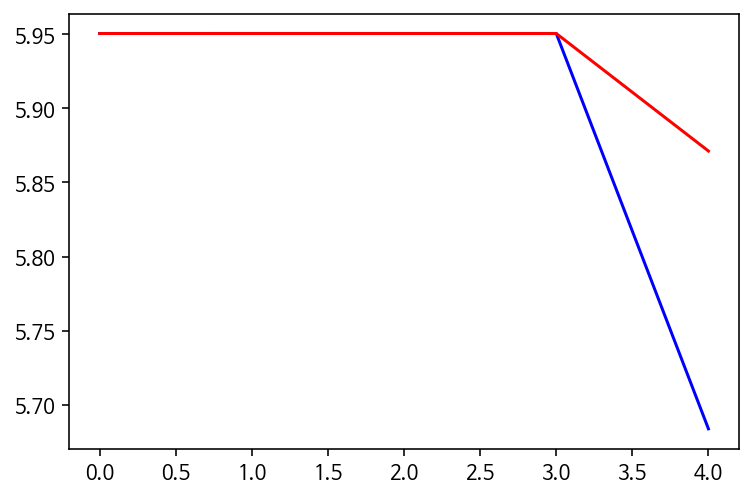

In [72]:
plt.plot(start_loss_list, 'b')
plt.plot(end_loss_list, 'r')

### 2.4 Bert Inference

In [73]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = ChunSik.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = ChunSik.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [ChunSik.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return ChunSik.decode_pieces(answer_tokens)

In [74]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = ChunSik.decode_pieces(data['question'])
        context = ChunSik.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

40
질문 :  하나님의 명령에 배를 만들고 가족과 짐승들을 배에 태워 홍수를 피한 사람은 누구인가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스팔트와 비슷한 성분)을 칠하여 굳혔다고 기록하고 있다.
정답 :  노아
예측 :  ~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 1 



## 3. Pretrained Model

### 3.1 pretrained model loading

In [75]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(ChunSik), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_73 (Dense)            multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


### 3.2 pretrained model training

In [76]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# 학습과정 시각화
pre_start_loss_list = []
pre_end_loss_list = []
pre_start_acc_list = []
pre_end_acc_list = []

pre_val_start_loss_list = []
pre_val_end_loss_list = []
pre_val_start_acc_list = []
pre_val_end_acc_list = []

best_acc = .0
patience = 0
for epoch in range(10):
    # train set 학습
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, train_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # 학습과정 시각화
    pre_start_loss_list.append(start_loss)
    pre_end_loss_list.append(end_loss)
    pre_start_acc_list.append(start_acc)
    pre_end_acc_list.append(end_acc)
    
    # validation set 학습
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # 학습과정 시각화
    pre_val_start_loss_list.append(start_loss)
    pre_val_end_loss_list.append(end_loss)
    pre_val_start_acc_list.append(start_acc)
    pre_val_end_acc_list.append(end_acc)
    
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.1417, 1.3133, acc: 0.7012, 0.6675


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.7703, 1.9849, acc: 0.5407, 0.5107
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 0.4077, 0.5024, acc: 0.8853, 0.8620


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 2.0030, 2.2880, acc: 0.5634, 0.5214
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

이거 또한 강제로 멈처 주었습니다.

### 3.3 Inference

In [77]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = ChunSik.decode_pieces(data['question'])
        context = ChunSik.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

## 4. 비교 분석

In [80]:
len(pre_start_loss_list), len(pre_end_loss_list), len(pre_start_acc_list), len(pre_end_acc_list)
len(pre_val_start_loss_list), len(pre_val_end_loss_list), len(pre_val_start_acc_list), len(pre_val_end_acc_list)

(2, 2, 2, 2)

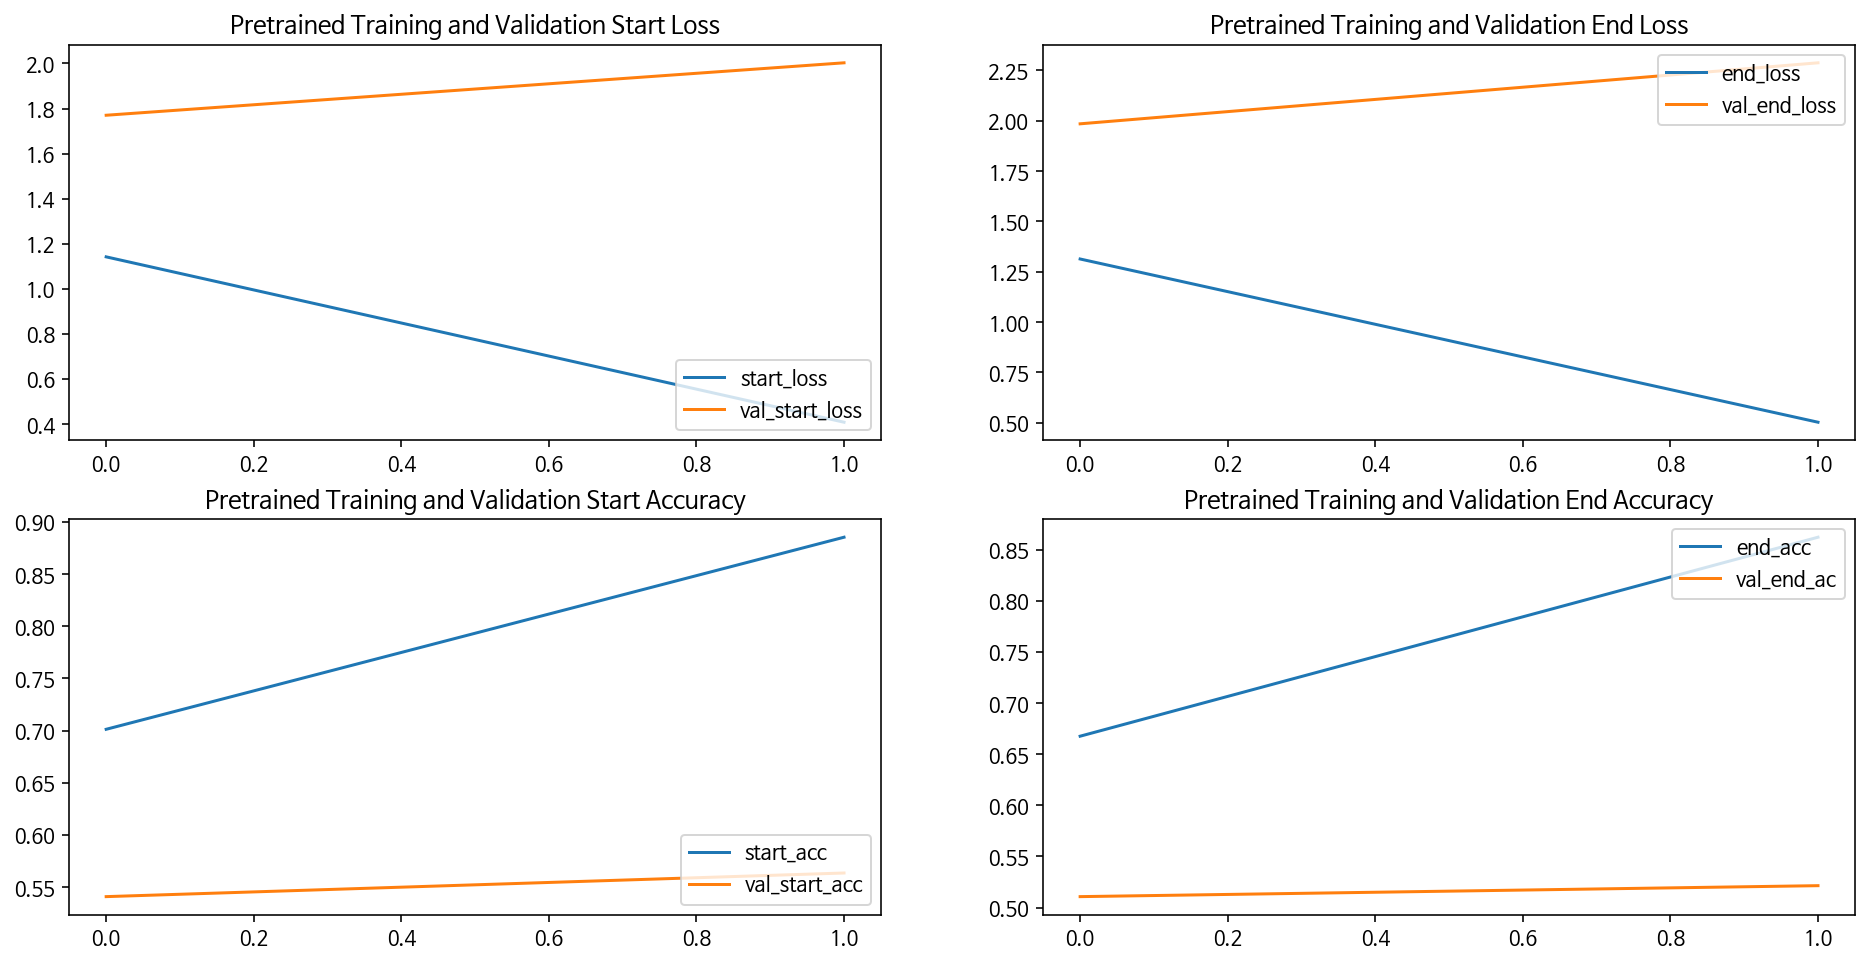

In [81]:
epochs_range = range(len(pre_start_loss_list))

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, pre_start_loss_list, label='start_loss')
plt.plot(epochs_range, pre_val_start_loss_list, label='val_start_loss')
plt.legend(loc='lower right')
plt.title('Pretrained Training and Validation Start Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, pre_end_loss_list, label='end_loss')
plt.plot(epochs_range, pre_val_end_loss_list, label='val_end_loss')
plt.legend(loc='upper right')
plt.title('Pretrained Training and Validation End Loss')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, pre_start_acc_list, label='start_acc')
plt.plot(epochs_range, pre_val_start_acc_list, label='val_start_acc')
plt.legend(loc='lower right')
plt.title('Pretrained Training and Validation Start Accuracy')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, pre_end_acc_list, label='end_acc')
plt.plot(epochs_range, pre_val_end_acc_list, label='val_end_ac')
plt.legend(loc='upper right')
plt.title('Pretrained Training and Validation End Accuracy')

plt.show()

In [82]:
print(max(val_end_acc_list), max(pre_val_end_acc_list))

tf.Tensor(0.005266854, shape=(), dtype=float32) tf.Tensor(0.5214185, shape=(), dtype=float32)


In [83]:
print(max(val_end_loss_list), max(pre_val_end_loss_list))

tf.Tensor(5.9506364, shape=(), dtype=float32) tf.Tensor(2.2879868, shape=(), dtype=float32)


## 5.회고

1. 우선 이번 노드는 설치 할 게 너무 많았다.  
특히 1.2.6의 Word Cloud 부분에서는 코랩에 한글이 없어서 오류가 나왔고 구글링을 통해 간신히 찾아 해결 할 수 있었다.

2. GPU? TPU?  
처음에는 행렬 연산에 병렬로 특화 되어 있는 TPU로 모델을 돌렸는데 정말 계산의 속도가 너무 느렸다.  
그래서 런타임 유형 변경을 통해 GPU로 바꾸니 전보다는 훨씬 더 빠른 속도로 계산이 되어서 간신히 마무리 할 수 있었다.  

3. LMS의 커널  
이번 익스 역시도 LMS 쥬피터로 돌리니 커널이 계속 죽었다.  
이 정도면 이렇게 무거운 모델을 돌릴때는 결국 코랩이 제일 좋다고 생각이 든다.  

4. 모델 레이어의 층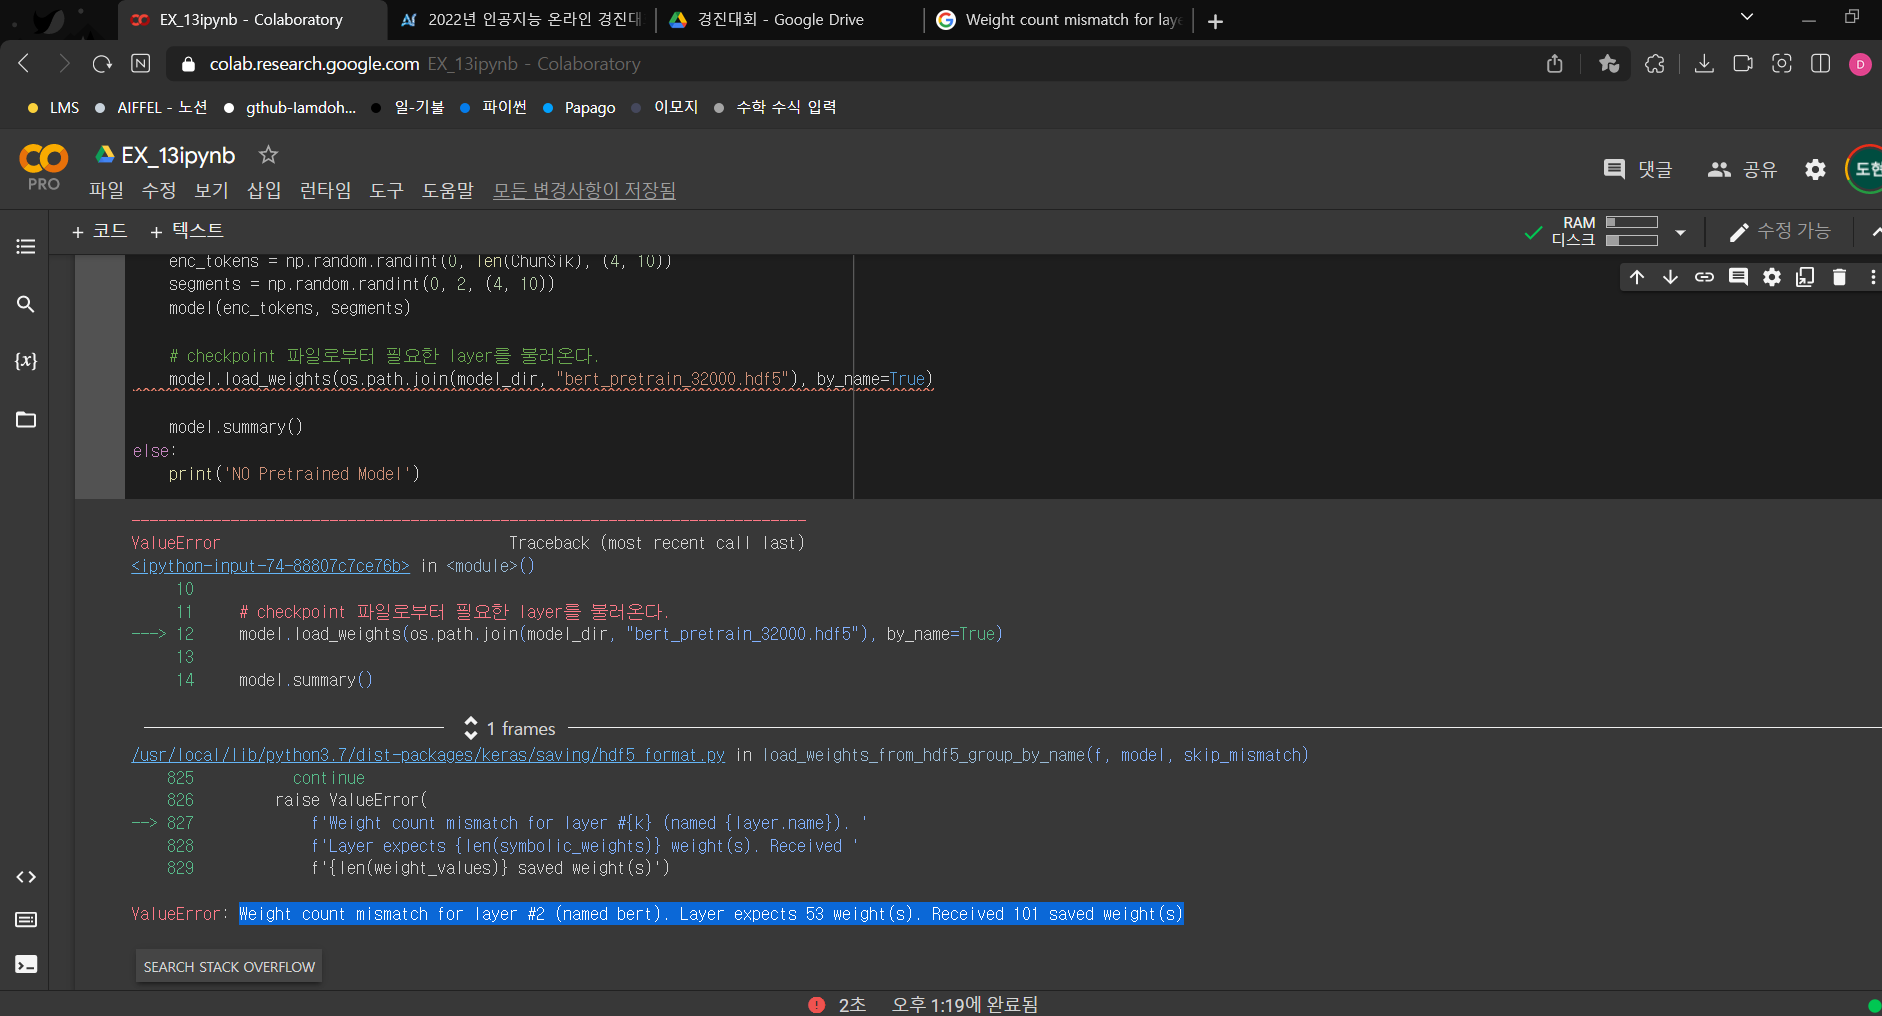

모델의 층이 맞지 않아서 아러한 문제가 생겼다.
위의 config 설정하는 부분에서 숫자를 조정하니 이러한 문제가 생겼고 층을 2배씩 늘려주니 다행히도 해결이 되었다.

5. 학습시간
정말 오래걸린다.  
이 정도면 가벼운 모델은 아니라는 생각이 드며 몇번을 다시 시작하고 새로 돌렸는지 가늠이 잡히지 않는다.  
3일 동안 쉴 틈 없이 돌렸고 오류가 날 때 마다 정말 좌절을 경험 하였지만 그럼에도 잘 해결 된 것 같다는 생각이 든다. 
